In [1]:
import numpy as np
from numpy import array
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model, Model, save_model
from tensorflow.keras.layers import LayerNormalization, Dense, Activation, Flatten, Conv3D, Conv2D, Conv1D, Dropout, MaxPooling2D, LeakyReLU, BatchNormalization, Reshape, InputLayer, Input, ZeroPadding3D, ZeroPadding2D, UpSampling2D, UpSampling3D, MaxPool3D, MaxPooling3D
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from keras import backend as K
NUM_FRAMES = 10
RESOLUTION = 32
CHANNELS = 1
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'}

In [2]:
# example of horizontal shift image augmentation
from numpy import expand_dims
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
# load the image

def load_dataset():    
    # Download and load the dataset.
    fpath = keras.utils.get_file(
        "moving_mnist.npy",
        "http://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy",
    )
    dataset = np.load(fpath)    
    dataset = np.swapaxes(dataset, 0, 1)
    dataset = np.expand_dims(dataset, 4)    
    dataset = dataset[:, :, ::2, ::2, :]  
    return dataset

dataset_20 = load_dataset()
dataset0 = dataset_20[:, :10, ...]
dataset1 = dataset_20[:, 10:, ...]
#print(dataset0.shape)
dataset = np.concatenate((dataset0, dataset1))
#print(dataset.shape)

# Split into train and validation sets using indexing to optimize memory.
indexes = np.arange(dataset.shape[0])
np.random.seed(42)
np.random.shuffle(indexes)
train_index = indexes[: int(0.8 * dataset.shape[0])]
val_index = indexes[int(0.8 * dataset.shape[0]) : int(0.95 * dataset.shape[0])]
test_index = indexes[int(0.95 * dataset.shape[0]) :]

train_dataset = (dataset[train_index] / 255.)
val_dataset = (dataset[val_index] / 255.)
test_dataset = (dataset[test_index] / 255.)

print(train_dataset.shape)

(16000, 10, 32, 32, 1)


In [3]:
def create_triad_dataset(dataset):
    x_triad_dataset = np.zeros((len(dataset), NUM_FRAMES, 3, RESOLUTION, RESOLUTION, CHANNELS))
    y_triad_dataset = np.zeros((len(dataset), NUM_FRAMES, 3, RESOLUTION, RESOLUTION, CHANNELS))
    
    for i, animation in enumerate(dataset):        
        x_triads = create_triad_animation(animation, True)
        x_triads = np.concatenate([x_triads, create_single_triad(animation, NUM_FRAMES - 2, NUM_FRAMES - 1, NUM_FRAMES - 1, True)], axis=0)        
        x_triads = np.concatenate([create_single_triad(animation, 0, 0, 1, True), x_triads], axis=0)                
        x_triad_dataset[i] = x_triads
        
        y_triads = create_triad_animation(animation, False)
        y_triads = np.concatenate([y_triads, create_single_triad(animation, NUM_FRAMES - 2, NUM_FRAMES - 1, NUM_FRAMES - 1, False)], axis=0)        
        y_triads = np.concatenate([create_single_triad(animation, 0, 0, 1, False), y_triads], axis=0)                
        y_triad_dataset[i] = y_triads
    
    return x_triad_dataset, y_triad_dataset
    
def create_triad_animation(animation, train):    
    animation_triads = np.zeros((0, 3, RESOLUTION, RESOLUTION, CHANNELS))    
    animation_triads = create_triad(animation, animation_triads, 0, len(animation) - 1, train)        
    return(animation_triads)

def create_triad(animation, animation_triads, start, end, train):        
    if start >= end - 1 or end <= start - 1:
        return animation_triads  
        
    middle = end-((end - start)//2)
    #print(f"Start: {start}, Middle: {middle}, End: {end}, Len: {len(animation_triads)}")
    
    triad = create_single_triad(animation, start, middle, end, train)
        
    animation_triads = np.concatenate([animation_triads, triad], axis=0)        
    animation_triads = create_triad(animation, animation_triads, start, middle, train)    
    animation_triads = create_triad(animation, animation_triads, middle, end, train)
    return animation_triads

def create_single_triad(animation, start, middle, end, train):
    triad = np.zeros((1, 3, RESOLUTION, RESOLUTION, CHANNELS))
    triad[0][0] = animation[start]
    if train:        
        triad[0][1] = 1
    else:
        triad[0][1] = animation[middle]
    triad[0][2] = animation[end]    
    return triad

In [4]:
x_train, y_train = create_triad_dataset(train_dataset[:, :, :, :, :])
x_val, y_val = create_triad_dataset(val_dataset[:, :, :, :, :])

size = x_train.nbytes + y_train.nbytes + x_val.nbytes + y_val.nbytes
print(f"Size arrays: {size * 1e-9} GB")

print(f"x_train: {x_train.shape}")
print(f"y_train: {y_train.shape}")

print(f"x_val: {x_val.shape}")
print(f"y_val: {y_val.shape}")

Size arrays: 9.338880000000001 GB
x_train: (16000, 10, 3, 32, 32, 1)
y_train: (16000, 10, 3, 32, 32, 1)
x_val: (3000, 10, 3, 32, 32, 1)
y_val: (3000, 10, 3, 32, 32, 1)


In [5]:
import gc

del dataset
del train_dataset
del val_dataset

gc.collect()

0

(160000, 3, 32, 32, 1)


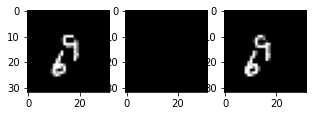

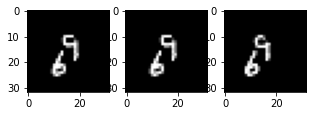

In [6]:
def check_triads(triads_x, triads_y):
    for i in range(len(triads_x)):
        check_triad = triads_x[i]
        fig, axes = plt.subplots(1, 3, figsize=(5, 5))
        ax = axes.flatten()
        ax[0].imshow(check_triad[0], cmap='gray')
        ax[1].imshow(check_triad[1], cmap='gray')
        ax[2].imshow(check_triad[2], cmap='gray')
        plt.show()
        check_triad = triads_y[i]
        fig, axes = plt.subplots(1, 3, figsize=(5, 5))
        ax = axes.flatten()
        ax[0].imshow(check_triad[0], cmap='gray')
        ax[1].imshow(check_triad[1], cmap='gray')
        ax[2].imshow(check_triad[2], cmap='gray')
        plt.show()

x_train = np.reshape(x_train, (len(x_train) * NUM_FRAMES, 3, RESOLUTION, RESOLUTION, CHANNELS))
y_train = np.reshape(y_train, (len(y_train) * NUM_FRAMES, 3, RESOLUTION, RESOLUTION, CHANNELS))
x_val = np.reshape(x_val, (len(x_val) * NUM_FRAMES, 3, RESOLUTION, RESOLUTION, CHANNELS))
y_val = np.reshape(y_val, (len(y_val) * NUM_FRAMES, 3, RESOLUTION, RESOLUTION, CHANNELS))

print(x_train.shape)
check_triads(x_train[30:31,:,:,:,:], y_train[30:31,:,:,:,:])

In [7]:
# Display animation
def display_original_animation(dataset, label=''):             
    fig, axes = plt.subplots(1, NUM_FRAMES, figsize=(25, 5))
    ax = axes.flat
    for i, data in enumerate(dataset[:NUM_FRAMES]):                
        ax[i].imshow(dataset[i], cmap='gray', vmin=0., vmax=1.)        
        ax[i].set_title(f"{label} {i}", fontsize=32)
        ax[i].axis("off")      
    plt.show()

In [8]:
def display_triad(triad):
    # Construct a figure for the original and new frames.
    fig, axes = plt.subplots(1, 3, figsize=(20, 4))

    # Plot the original frames.
    for idx, ax in enumerate(axes):
        ax.imshow(np.squeeze(triad[0][idx]), cmap="gray")
        ax.set_title(f"OG {idx}")
        ax.axis("off")
    plt.show()

In [9]:
def create_predict_triad(start_frame, end_frame):
    frames = np.zeros((1, 3, 32, 32, 1))
    frames[0][0] = start_frame
    frames[0][1] = 1
    frames[0][2] = end_frame
    return frames

In [10]:
def predict_animations(real_first_frame, real_last_frame):    
    x = np.zeros((NUM_FRAMES, 32, 32, 1))    
    x[0] = real_first_frame
    x[len(x)-1] = real_last_frame
    array = predict_recursively(x, 0, len(x)-1)
    print(array.shape)
    return array

def predict_recursively(array, pos_start, pos_end):       
    pos_middle = pos_end-((pos_end-pos_start)//2)
    #print(pos_middle)
    if not np.all(array[pos_middle] == 0):
        #print(f"Already predicted: {pos_middle}")
        return array
    
    if (pos_end - pos_start ) <= 1:
        #print("End")
        return array
        
    new_icon_triad = create_predict_triad(array[pos_start], array[pos_end])    
    new_predicted_triad = model.predict(new_icon_triad)
    new_predicted_triad[0][0] = array[0]
    new_predicted_triad[0][2] = array[len(array)-1]    
    """
    check_triad = new_predicted_triad[0][1]
    fig, axes = plt.subplots(1, 1, figsize=(5, 5))
    axes.imshow(check_triad, cmap='gray')    
    plt.show()
    """
    #print(f"start: {pos_start}, mid: {pos_middle}, end: {pos_end}")
    array[pos_middle] = new_predicted_triad[0][1]
    if pos_middle == NUM_FRAMES // 2:
        print(f"{pos_start} {pos_middle}")
        
    go_left = predict_recursively(array, pos_start, pos_middle)
    go_right = predict_recursively(array, pos_middle, pos_end)
    return np.max([go_left, go_right],axis=0)

In [11]:
img_shape = x_train[0].shape
print(img_shape)

class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean
    
def build_model():
    codings_size = 1
    print("codings_size: ", codings_size)
    inputs = Input(shape=img_shape)
    layers_encoder = 8
    layers_decoder = 16
    layer_activation ='selu'
    output_activation = 'tanh'
    optimizer = 'nadam'
    kernel_size = 3
    
    z = Conv3D(filters=32, kernel_size=kernel_size, activation=layer_activation, padding='same', kernel_initializer='GlorotNormal')(inputs)
    for i in range(layers_encoder):    
        z = Conv3D(filters=32, kernel_size=kernel_size, activation=layer_activation, padding='same', kernel_initializer='GlorotNormal')(z)
        z = LayerNormalization(axis=[2,3])(z)
    codings_mean = Dense(codings_size)(z)
    codings_log_var = Dense(codings_size)(z)
    codings = Sampling()([codings_mean, codings_log_var])
    encoder = Model(inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])        
    
    decoder_inputs = Input(shape=(3,32,32,1))
    x = Conv3D(filters=32, kernel_size=kernel_size, activation=layer_activation, padding='same', kernel_initializer='GlorotNormal')(decoder_inputs)
    for i in range(layers_decoder):    
        x = Conv3D(filters=32, kernel_size=kernel_size, activation=layer_activation, padding='same', kernel_initializer='GlorotNormal')(x)
        x = LayerNormalization(axis=[2,3])(x)
    x = Conv3D(filters=1, kernel_size=kernel_size, activation=output_activation, padding='same', kernel_initializer='GlorotNormal')(x)
    decoder = Model(inputs=[decoder_inputs], outputs=[x])
    
    _, _, codings = encoder(inputs)
    reconstructions = decoder(codings)
    variational_ae = Model(inputs=[inputs], outputs=[reconstructions])
    
    latent_loss = -0.5 * K.sum(1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean), axis=-1)
    variational_ae.add_loss(K.mean(latent_loss / 1024.))
    variational_ae.compile(loss='mse', optimizer=optimizer)
    
    return variational_ae

(3, 32, 32, 1)


In [13]:
import time
import pickle
start_time = time.time()
LOG_DIR = f"./logs/{int(time.time())}"

# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=6)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=3)
model = build_model()
model.fit(
    x=x_train,
    y=y_train,
    epochs=100,
    batch_size=128,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, reduce_lr] # keras.callbacks.TensorBoard("./tb_logs")
    )

import pickle
checkpoint_filepath = './savedModels/03_Recursive_conv_vae_v04_04_layerNorm.pickle'
with open(checkpoint_filepath, "wb") as save_file:
    pickle.dump(model, save_file)
with open(checkpoint_filepath, "rb") as load_file:    
    model = pickle.load(load_file)

print("--- %s minutes ---" % ((time.time() - start_time) / 60))

codings_size:  1
Epoch 1/100
1250/1250 [==============================] - 1561s 1s/step - loss: 0.0246 - val_loss: 0.0123 - lr: 0.0010
Epoch 2/100
1250/1250 [==============================] - 1577s 1s/step - loss: 0.0100 - val_loss: 0.0088 - lr: 0.0010
Epoch 3/100
1250/1250 [==============================] - 1578s 1s/step - loss: 0.0084 - val_loss: 0.0077 - lr: 0.0010
Epoch 4/100
1250/1250 [==============================] - 1577s 1s/step - loss: 0.0074 - val_loss: 0.0068 - lr: 0.0010
Epoch 5/100
1250/1250 [==============================] - 1576s 1s/step - loss: 0.0067 - val_loss: 0.0064 - lr: 0.0010
Epoch 6/100
1250/1250 [==============================] - 1578s 1s/step - loss: 0.0063 - val_loss: 0.0061 - lr: 0.0010
Epoch 7/100
1250/1250 [==============================] - 1577s 1s/step - loss: 0.0060 - val_loss: 0.0060 - lr: 0.0010
Epoch 8/100
1250/1250 [==============================] - 1578s 1s/step - loss: 0.0058 - val_loss: 0.0058 - lr: 0.0010
Epoch 9/100
1250/1250 [================

In [14]:
pickle_in = open(checkpoint_filepath, "rb")

In [15]:
# Clamp images, else the predictions get very blurry
# theta: threshold to decide where to clip values
# epsilon: keep some values unclipped, to avoid too jagged edges
def clamp_image_array(y_hat, theta=.3, epsilon=.1):        
    y_hat_p = np.where(y_hat < theta - epsilon, 0, y_hat)
    y_hat_p = np.where(y_hat_p >= theta + epsilon, 1, y_hat_p)
    return y_hat_p

0 5
(10, 32, 32, 1)


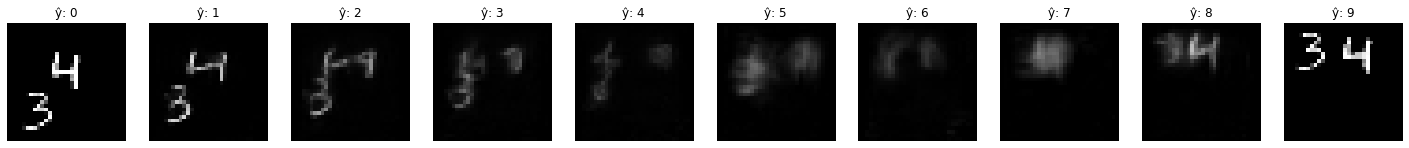

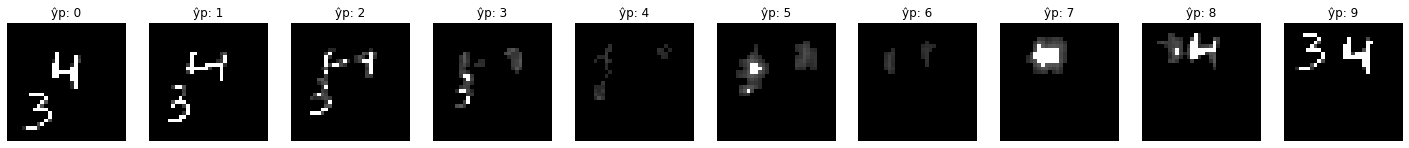

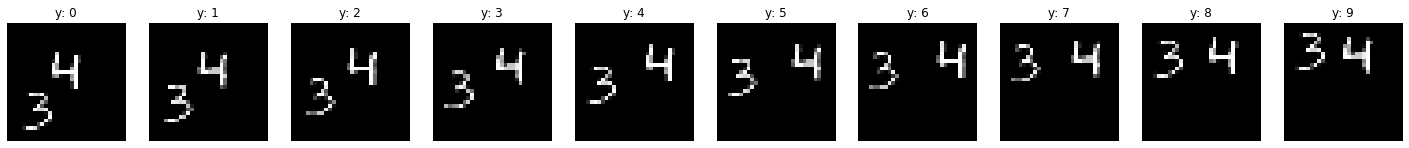

0 5
(10, 32, 32, 1)


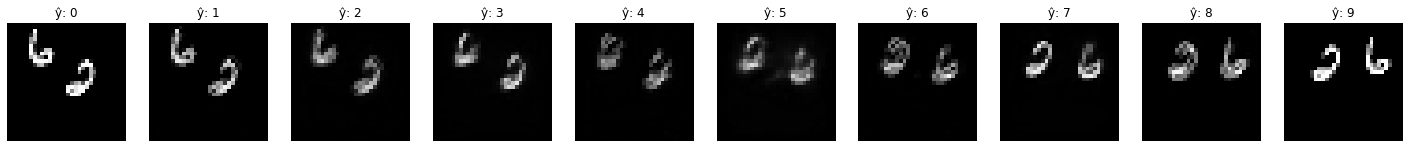

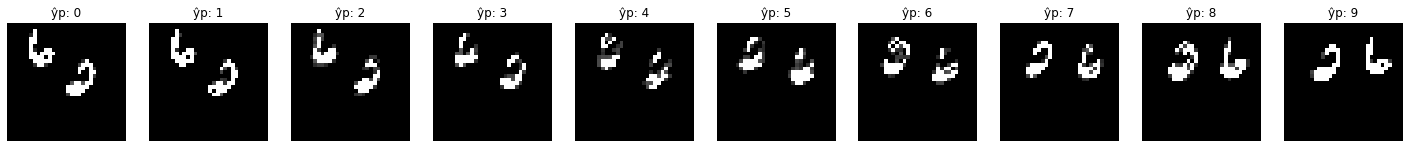

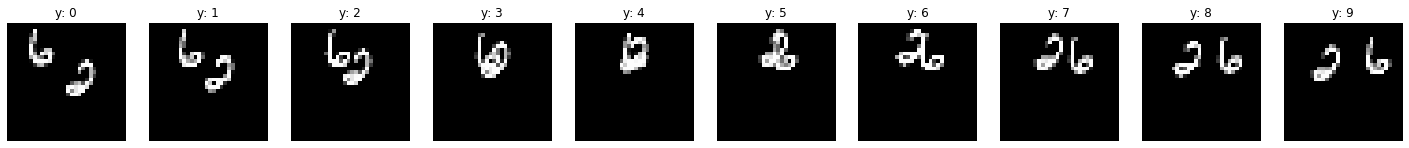

0 5
(10, 32, 32, 1)


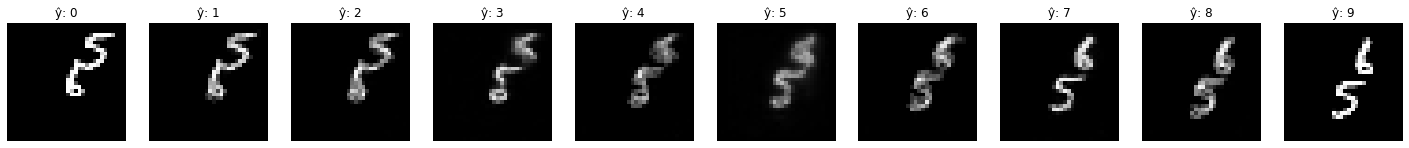

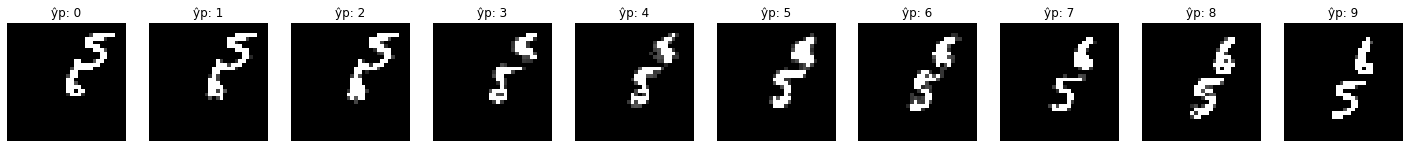

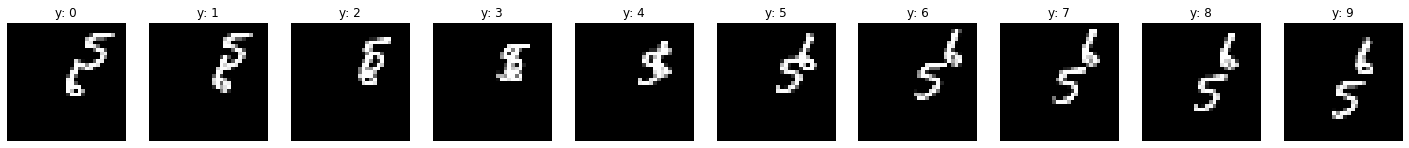

0 5
(10, 32, 32, 1)


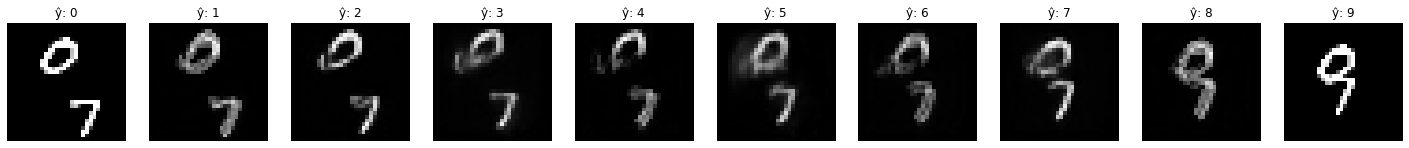

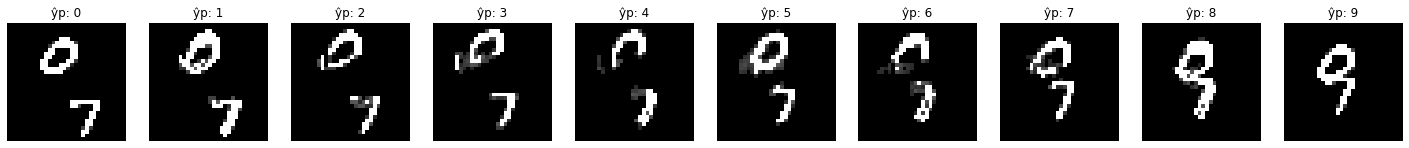

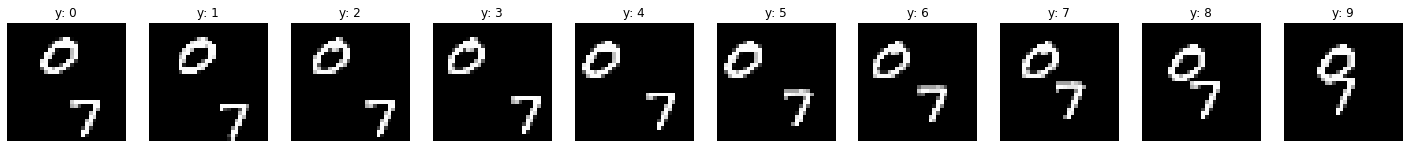

0 5
(10, 32, 32, 1)


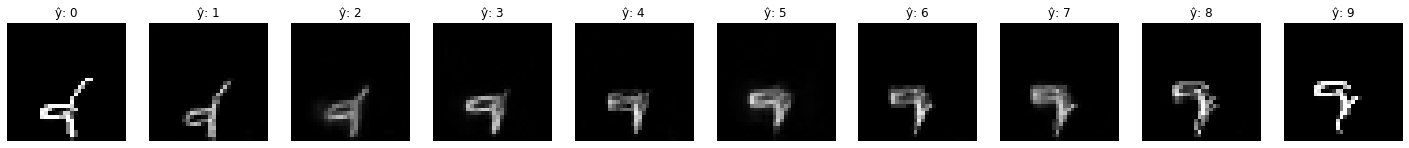

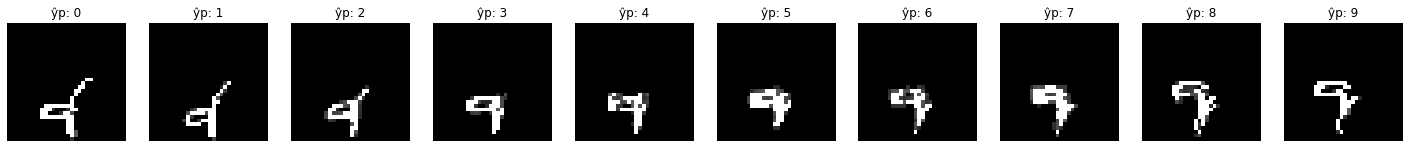

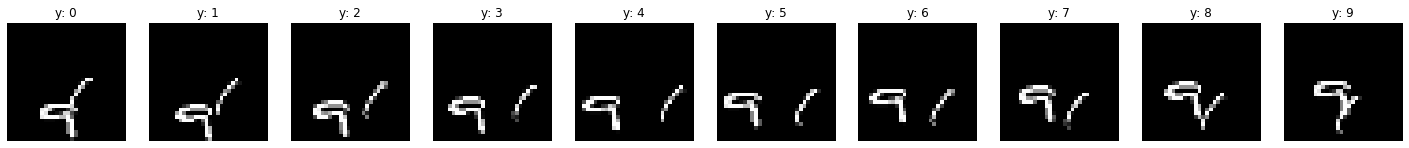

0 5
(10, 32, 32, 1)


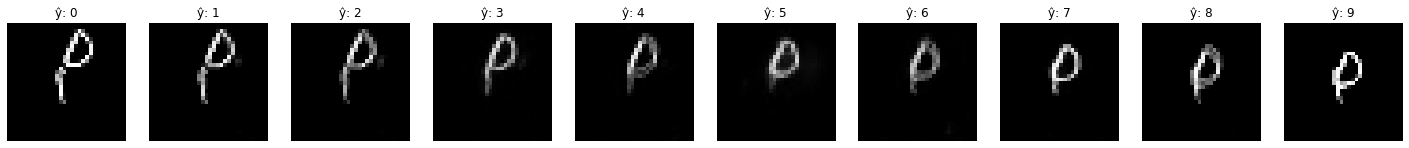

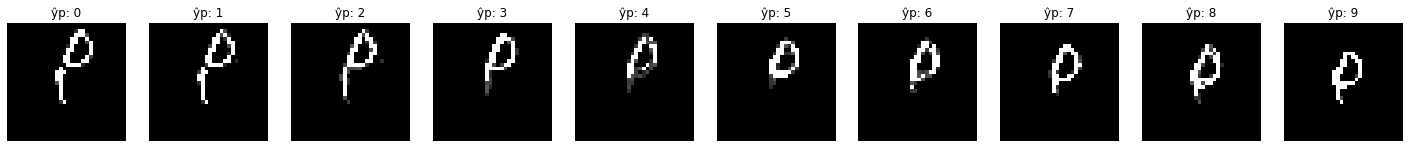

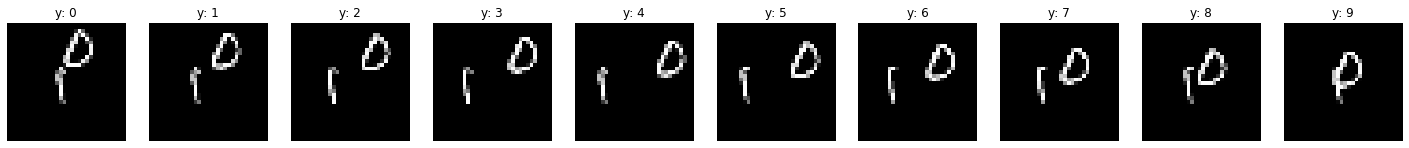

0 5
(10, 32, 32, 1)


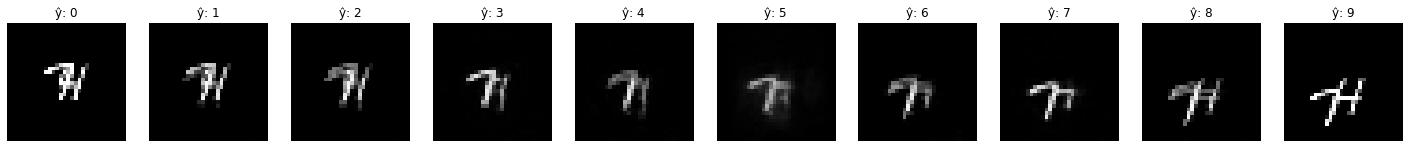

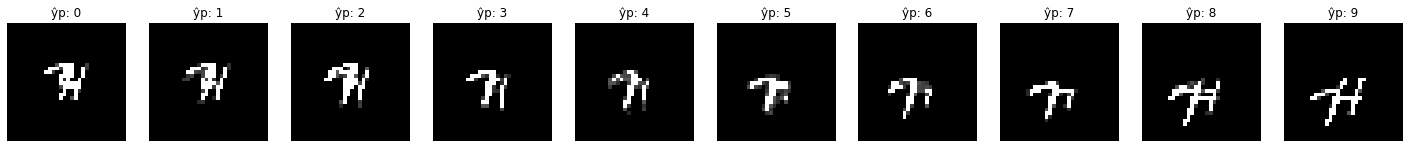

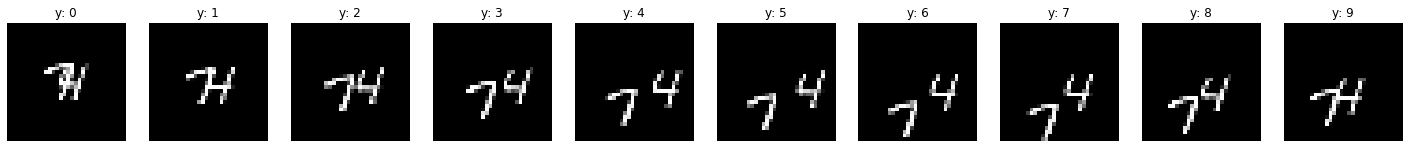

In [16]:
good = [22, 44, 52, 64, 73, 76, 94]
for i in good:
    test_set = test_dataset[i]
    y_hat = predict_animations(test_set[0], test_set[len(test_set)-1])
    
    display_original_animation(y_hat)
    display_original_animation(clamp_image_array(y_hat, theta=.35, epsilon=0.15))
    display_original_animation(test_set)